In [3]:
from __future__ import division, print_function, unicode_literals

import tensorflow as tf

# Common imports
import numpy as np
import os
import sys
from functools import partial

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

he_init = tf.contrib.layers.variance_scaling_initializer() # He initialization
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense_layer = partial(tf.layers.dense,
                         activation=tf.nn.elu,
                         kernel_initializer=he_init,
                         kernel_regularizer=l2_regularizer)

hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3 = my_dense_layer(hidden2, n_hidden3)
outputs = my_dense_layer(hidden3, n_outputs, activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver() 

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") 
            sys.stdout.flush()                                         
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})   
        print("\r{}".format(epoch), "Train MSE:", loss_train)           
        saver.save(sess, "./my_model_all_layers.ckpt")                 

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
0 Train MSE: 0.020531
1 %Train MSE: 0.0120206
2 Train MSE: 0.0107345
39% Train MSE: 0.00967614
4 Train MSE: 0.0100528


In [5]:
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")
    
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

INFO:tensorflow:Restoring parameters from ./my_model_all_layers.ckpt
Saving figure reconstruction_plot


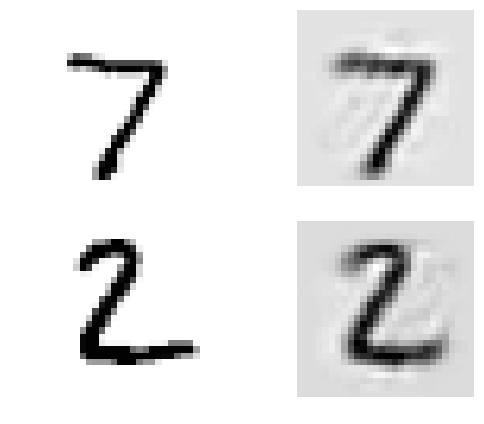

In [6]:
show_reconstructed_digits(X, outputs, "./my_model_all_layers.ckpt")
save_fig("reconstruction_plot")

In [7]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)


In [8]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

In [9]:

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3")  # tied weights
weights4 = tf.transpose(weights1, name="weights4")  # tied weights

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [10]:
saver = tf.train.Saver()

In [11]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_tying_weights.ckpt")

0 Train MSE: 0.0159341
1 Train MSE: 0.0164315
2 Train MSE: 0.0167725
3 Train MSE: 0.0174328
4 Train MSE: 0.0177267


In [12]:

reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])
weights4_init = initializer([n_hidden3, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [13]:
optimizer = tf.train.AdamOptimizer(learning_rate)

with tf.name_scope("phase1"):
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)

with tf.name_scope("phase2"):
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [weights2, biases2, weights3, biases3]
    phase2_training_op = optimizer.minimize(phase2_loss, var_list=train_vars)

In [14]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [15]:

training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                sess.run(training_ops[phase], feed_dict={X: X_batch})
            loss_train = reconstruction_losses[phase].eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "./my_model_one_at_a_time.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", loss_test)

Training phase #1
0 Train MSE: 0.00804847
1 Train MSE: 0.0074826
2 Train MSE: 0.00763566
3 Train MSE: 0.00776686
Training phase #2
0 Train MSE: 0.220101
1 Train MSE: 0.0044097
2 Train MSE: 0.00240984
3 Train MSE: 0.00192531
Test MSE: 0.00972138


In [16]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

import numpy.random as rnd
rnd.permutation(1)


with tf.Session() as sess:
    init.run()
    
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        if phase == 1:
            hidden1_cache = hidden1.eval(feed_dict={X: mnist.train.images})
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                if phase == 1:
                    indices = rnd.permutation(mnist.train.num_examples)
                    hidden1_batch = hidden1_cache[indices[:batch_sizes[phase]]]
                    feed_dict = {hidden1: hidden1_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
                else:
                    X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                    feed_dict = {X: X_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
            loss_train = reconstruction_losses[phase].eval(feed_dict=feed_dict)
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "./my_model_cache_frozen.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", loss_test)
    
    tvars = tf.trainable_variables()
    
    tvars_vals = sess.run(tvars)
    
    for var, val in zip(tvars, tvars_vals):
        print(var.name, val) 

Training phase #1
0 Train MSE: 0.00774872
1 Train MSE: 0.00749705
2 Train MSE: 0.00765727
3 Train MSE: 0.00768713
Training phase #2
0 Train MSE: 0.191614
1 Train MSE: 0.00513991
2 Train MSE: 0.00258615
3 Train MSE: 0.00206444
Test MSE: 0.00980091
weights1:0 [[ -3.01917848e-32   4.76019376e-33  -1.31524829e-32 ...,   7.93909294e-07
   -4.53817756e-32  -7.23645137e-32]
 [ -4.56205655e-32   4.50903294e-32  -8.51394454e-32 ...,   6.24020463e-32
    3.98086217e-32  -2.08346144e-12]
 [  6.66831849e-32  -3.04659924e-33  -8.69466152e-34 ...,   6.73385465e-33
   -5.99417954e-32   5.58566704e-33]
 ..., 
 [ -2.11109193e-31   5.37719546e-32  -1.46131580e-34 ...,   2.58409041e-32
    2.26940322e-32  -1.27795067e-31]
 [  2.06705157e-32   5.76183602e-32  -1.78907325e-30 ...,  -7.38883423e-32
    7.72919274e-33   3.56996400e-32]
 [  2.80455849e-32  -4.06360404e-32   1.39505812e-31 ...,  -2.28120477e-31
   -1.03827607e-31  -3.55114727e-32]]
weights2:0 [[ 0.01091096 -0.01067686  0.01005889 ...,  0.00444

INFO:tensorflow:Restoring parameters from ./my_model_one_at_a_time.ckpt
Saving figure extracted_features_plot


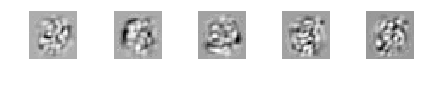

In [17]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_one_at_a_time.ckpt") 
    weights1_val = weights1.eval()

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plot_image(weights1_val.T[i])

save_fig("extracted_features_plot") 
plt.show()                          

In [18]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_outputs = 10

learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.int32, shape=[None])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
logits = tf.matmul(hidden2, weights3) + biases3

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
reg_loss = regularizer(weights1) + regularizer(weights2) + regularizer(weights3)
loss = cross_entropy + reg_loss
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
pretrain_saver = tf.train.Saver([weights1, weights2, biases1, biases2])
saver = tf.train.Saver()

In [19]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end=" ")
        saver.save(sess, "./my_model_supervised.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

0 Train accuracy: 0.94 Test accuracy: 0.9185
1 Train accuracy: 0.96 Test accuracy: 0.9447
2 Train accuracy: 0.96 Test accuracy: 0.9487
3 Train accuracy: 0.986667 Test accuracy: 0.9467


In [20]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

#training_op = optimizer.minimize(loss, var_list=[weights3, biases3])  # Freeze layers 1 and 2 (optional)

with tf.Session() as sess:
    init.run()
    pretrain_saver.restore(sess, "./my_model_cache_frozen.ckpt")
    
    tvars = tf.trainable_variables()
    
    tvars_vals = sess.run(tvars)
    
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end="\t")
        saver.save(sess, "./my_model_supervised_pretrained.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)
    

        

INFO:tensorflow:Restoring parameters from ./my_model_cache_frozen.ckpt
0 Train accuracy: 0.933333	Test accuracy: 0.9275
19% Train accuracy: 0.966667	Test accuracy: 0.9479
2 Train accuracy: 0.986667	Test accuracy: 0.9354
3 Train accuracy: 0.98	Test accuracy: 0.9463


In [21]:

reset_graph()

n_inputs = 28 * 28
n_hidden1 = 1000  # sparse codings
n_outputs = n_inputs

In [22]:
def kl_divergence(p, q):
    # Kullback Leibler divergence
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2

X = tf.placeholder(tf.float32, shape=[None, n_inputs])            

hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid) 
outputs = tf.layers.dense(hidden1, n_outputs)                     

hidden1_mean = tf.reduce_mean(hidden1, axis=0) # batch mean
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean))
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE
loss = reconstruction_loss + sparsity_weight * sparsity_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [23]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [24]:

n_epochs = 100
batch_size = 1000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss, sparsity_loss, loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", reconstruction_loss_val, "\tSparsity loss:", sparsity_loss_val, "\tTotal loss:", loss_val)
        saver.save(sess, "./my_model_sparse.ckpt")

0 Train MSE: 0.131474 	Sparsity loss: 0.215301 	Total loss: 0.174534
1 Train MSE: 0.0592777 	Sparsity loss: 0.151371 	Total loss: 0.0895519
2 Train MSE: 0.051831 	Sparsity loss: 0.0230559 	Total loss: 0.0564421
3 Train MSE: 0.0490905 	Sparsity loss: 0.096128 	Total loss: 0.0683161
4 Train MSE: 0.0455875 	Sparsity loss: 0.487191 	Total loss: 0.143026
5 Train MSE: 0.0409968 	Sparsity loss: 0.0135964 	Total loss: 0.0437161
6 Train MSE: 0.0381746 	Sparsity loss: 0.0182552 	Total loss: 0.0418256
7 Train MSE: 0.0367286 	Sparsity loss: 0.00857303 	Total loss: 0.0384432
8 Train MSE: 0.0332256 	Sparsity loss: 0.0206892 	Total loss: 0.0373634
9 Train MSE: 0.0316032 	Sparsity loss: 0.206591 	Total loss: 0.0729215
10 Train MSE: 0.0274669 	Sparsity loss: 0.0500361 	Total loss: 0.0374741
11 Train MSE: 0.0249979 	Sparsity loss: 0.0912406 	Total loss: 0.043246
12 Train MSE: 0.0232693 	Sparsity loss: 0.083458 	Total loss: 0.0399609
13 Train MSE: 0.0222022 	Sparsity loss: 0.0220444 	Total loss: 0.026611

In [25]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()

my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_sigma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_sigma), dtype=tf.float32)
hidden3 = hidden3_mean + hidden3_sigma * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)

In [26]:
eps = 1e-10 # smoothing term to avoid computing log(0) which is NaN
latent_loss = 0.5 * tf.reduce_sum(
    tf.square(hidden3_sigma) + tf.square(hidden3_mean)
    - 1 - tf.log(eps + tf.square(hidden3_sigma)))

In [27]:

loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [28]:

n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)
        saver.save(sess, "./my_model_variational.ckpt")

0 Train total loss: 37329.2 	Reconstruction loss: 24752.0 	Latent loss: 12577.2
1 Train total loss: 27862.8 	Reconstruction loss: 22940.8 	Latent loss: 4922.01
2 Train total loss: 33451.6 	Reconstruction loss: 24956.7 	Latent loss: 8494.88
3 Train total loss: 26332.3 	Reconstruction loss: 22116.7 	Latent loss: 4215.63
4 Train total loss: 22890.8 	Reconstruction loss: 19555.6 	Latent loss: 3335.16
5 Train total loss: 26012.7 	Reconstruction loss: 20393.3 	Latent loss: 5619.38
6 Train total loss: 27732.7 	Reconstruction loss: 20685.3 	Latent loss: 7047.35
79% Train total loss: 19750.9 	Reconstruction loss: 16613.8 	Latent loss: 3137.07
8 Train total loss: 18259.6 	Reconstruction loss: 15323.3 	Latent loss: 2936.32
9 Train total loss: 17937.6 	Reconstruction loss: 14881.3 	Latent loss: 3056.28
10 Train total loss: 16826.4 	Reconstruction loss: 13945.5 	Latent loss: 2880.89
11 Train total loss: 16918.8 	Reconstruction loss: 13869.7 	Latent loss: 3049.1
12 Train total loss: 16541.6 	Reconst

In [29]:
import numpy as np

n_digits = 60
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # not shown in the book
            sys.stdout.flush()                                          # not shown
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch}) # not shown
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)  # not shown
        saver.save(sess, "./my_model_variational.ckpt")  # not shown
    
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

0 Train total loss: 29700.2 	Reconstruction loss: 24572.7 	Latent loss: 5127.58
1 Train total loss: 27205.0 	Reconstruction loss: 22376.9 	Latent loss: 4828.15
2 Train total loss: 34899.8 	Reconstruction loss: 26630.1 	Latent loss: 8269.72
3 Train total loss: 23109.7 	Reconstruction loss: 20507.5 	Latent loss: 2602.24
4 Train total loss: 21507.7 	Reconstruction loss: 18644.1 	Latent loss: 2863.59
59% Train total loss: 22048.9 	Reconstruction loss: 18731.1 	Latent loss: 3317.81
6 Train total loss: 18788.7 	Reconstruction loss: 15634.3 	Latent loss: 3154.47
7 Train total loss: 18748.1 	Reconstruction loss: 15678.9 	Latent loss: 3069.2
8 Train total loss: 17156.9 	Reconstruction loss: 14144.8 	Latent loss: 3012.0
9 Train total loss: 16486.3 	Reconstruction loss: 13352.3 	Latent loss: 3134.02
10 Train total loss: 16244.7 	Reconstruction loss: 13112.6 	Latent loss: 3132.05
11 Train total loss: 21993.9 	Reconstruction loss: 17367.8 	Latent loss: 4626.14
12 Train total loss: 16388.0 	Reconstr

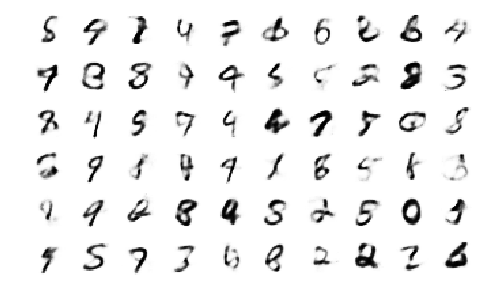

In [31]:

plt.figure(figsize=(8,50)) # not shown in the book
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])